# Medical Image Classification

**Company Use Case:**

**Approach:**

The following Notebook will show two approaches to do this with ConcreteML.

**Dataset Source:**

The data used is provided by MedMNIST v2, a comprehensive collection of standardized biomedical images. It encompasses 12 datasets for 2D and 6 for 3D images, pre-processed into 28 x 28 (2D) or 28 x 28 x 28 (3D) with corresponding classification labels. With 708,069 2D images and 9,998 3D images, it supports various classification tasks, from binary/multi-class to ordinal regression and multi-label, catering to biomedical image analysis, computer vision, and machine learning research and education.

https://medmnist.com/

**Dataset  1:**

_OCTMNIST_

MedMNIST Description:

The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.

https://zenodo.org/records/6496656/files/octmnist.npz?download=1

**Dataset 2:**

_PneumoniaMNIST_

MedMNIST Description:

The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.

https://zenodo.org/records/6496656/files/pneumoniamnist.npz?download=1

**Dataset 2:**

<span style="color:red">_NAME_</span> (Maybe BloodMNIST)

MedMNIST Description:

<span style="color:red">TEXT</span>

# FHE Mode

In [1]:
mode = 'simulate'

# mode = 'execute'

# Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# MedMNIST
import medmnist

# SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# XGBoost
from xgboost.sklearn import XGBClassifier

# PyTorch
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50, vgg16
from torchsummary import summary

In [3]:
# set random seed
np.random.seed(1)
torch.manual_seed(1)

# General Functions

In [4]:
###############################################################
# Logging (KICK AFTER BEING DONE)
###############################################################

def log_parameters():
    if os.path.isfile(f'{dataset}_Experiments.csv'):
        df = pd.read_csv(f'{dataset}_Experiments.csv')
        df = df.drop_duplicates()
        # append new row
        df = pd.concat([df, pd.DataFrame({
            'epochs': [epochs],
            'learning_rate': [learning_rate],
            'weight_decay': [weight_decay],
            'model': [str(model)],
            'final_train_loss': [train_losses[-1]],
            'final_train_accuracy': [train_accuracies[-1]],
            'final_val_loss': [val_losses[-1]],
            'final_val_accuracy': [val_accuracies[-1]]
            })])
        # save csv
        df.to_csv(f'{dataset}_Experiments.csv', index=False)

    else:
        df = pd.DataFrame({
        'epochs': [epochs],
        'learning_rate': [learning_rate],
        'weight_decay': [weight_decay],
        'model': [str(model)],
        'final_train_loss': [train_losses[-1]],
        'final_train_accuracy': [train_accuracies[-1]],
        'final_val_loss': [val_losses[-1]],
        'final_val_accuracy': [val_accuracies[-1]]
        })
        # save csv
        df.to_csv(f'{dataset}_Experiments.csv', index=False)
    
    return 'Parameters Logged!'

###############################################################
# Load Data
###############################################################

def load_data(dataset):

    '''
    Load data from MedMNIST

    Input:
        dataset (str): name of dataset

    Output:
    '''

    # initialize DataClass
    DataClass = getattr(medmnist, dataset)
    # download data
    train_dataset = DataClass(split='train',download=True)
    eval_dataset = DataClass(split='val', download=True)
    test_dataset = DataClass(split='test', download=True)
    # to numpy array
    xtrain, ytrain = train_dataset.imgs, train_dataset.labels
    xval, yval = eval_dataset.imgs, eval_dataset.labels
    xtest, ytest = test_dataset.imgs, test_dataset.labels
    # expand dimension (grayscale)
    # (channels=1, height=28, width=28)
    xtrain_gray = np.expand_dims(xtrain, axis=1)
    xval_gray = np.expand_dims(xval, axis=1)
    xtest_gray = np.expand_dims(xtest, axis=1)
    # expand dimension (rgb) - needed for pretrained models
    # (channels=3, height=28, width=28)
    xtrain_rgb = np.repeat(xtrain, 3, axis=1)
    xval_rgb = np.repeat(xval, 3, axis=1)
    xtest_rgb = np.repeat(xtest, 3, axis=1)

    X_grayscale = (xtrain_gray, xval_gray, xtest_gray)
    X_rgb = (xtrain_rgb, xval_rgb, xtest_rgb)
    y = (ytrain, yval, ytest)

    return X_grayscale, X_rgb, y

# Load Data

In [5]:
data = load_data(dataset='PneumoniaMNIST')

xtrain_gray, xval_gray, xtest_gray = data[0]
xtrain_rgb, xval_rgb, xtest_rgb = data[1]
ytrain, yval, ytest = data[2]

Using downloaded and verified file: /home/lukas/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/lukas/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/lukas/.medmnist/pneumoniamnist.npz


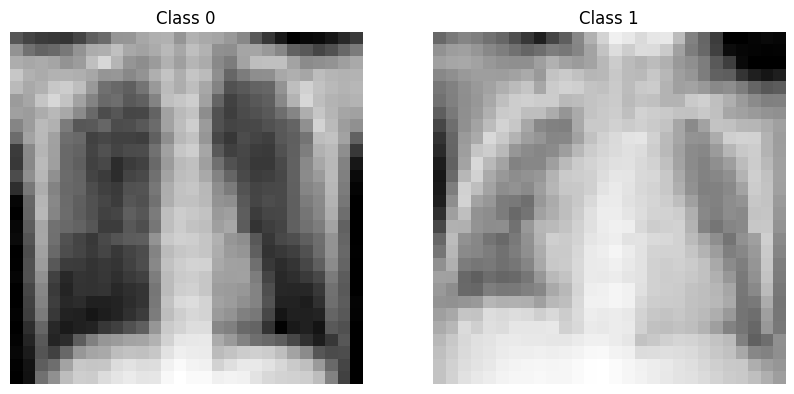

In [7]:
# plot sample images of each class
n_classes = len(np.unique(ytrain))

fig, ax = plt.subplots(nrows=1, ncols=n_classes, figsize=(10, 5))
for i in range(n_classes):
    ax[i].imshow(xtrain_gray[ytrain.flatten()==i][0][0], cmap='gray')
    ax[i].set_title(f'Class {i}')
    ax[i].axis('off')

# Preprocessing

# Modelling

## Approach 1: Convolutional Neural Network

In [ ]:
epochs = 30
learning_rate = 0.0001
weight_decay = 0.0001

In [ ]:
xtrain_tensor, ytrain_tensor = torch.tensor(xtrain, dtype=torch.float), torch.tensor(ytrain, dtype=torch.float)
xval_tensor, yval_tensor = torch.tensor(xval, dtype=torch.float), torch.tensor(yval, dtype=torch.float)
xtest_tensor, ytest_tensor = torch.tensor(xtest, dtype=torch.float), torch.tensor(ytest, dtype=torch.float)

In [ ]:
n_classes = len(np.unique(ytrain))

model = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5),
      torch.nn.ReLU(),
      torch.nn.AvgPool2d(kernel_size=2, stride=2),
      torch.nn.Conv2d(in_channels=2, out_channels=4, kernel_size=5),
      torch.nn.Flatten(),
      torch.nn.Linear(in_features=256, out_features=1, bias=True),
      torch.nn.Sigmoid()
)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

summary(model, input_size=(1, 28, 28))

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in tqdm(range(epochs)):
  # training
  model.train()
  for i in range(0, len(xtrain_tensor), 1):
    inputs = xtrain_tensor[i:i+1]
    labels = ytrain_tensor[i:i+1]

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # log metrics
  model.eval()
  with torch.no_grad():
    train_outputs = model(xtrain_tensor)
    train_loss = criterion(train_outputs, ytrain_tensor)
    predicted = torch.round(train_outputs)
    train_accuracy = accuracy_score(predicted.detach().numpy(), ytrain_tensor.detach().numpy())*100

    val_outputs = model(xval_tensor)
    val_loss = criterion(val_outputs, yval_tensor)
    predicted = torch.round(val_outputs)
    val_accuracy = accuracy_score(predicted.detach().numpy(), yval_tensor.detach().numpy())*100

  train_losses.append(train_loss.item())
  val_losses.append(val_loss.item())
  train_accuracies.append(train_accuracy)
  val_accuracies.append(val_accuracy)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='Training Loss')
ax[0].plot(val_losses, label='Validation Loss')
ax[0].set_xticks(np.arange(0, epochs, 1))
ax[0]. set_xlabel('Epochs')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(train_accuracies, label='Training Accuracy')
ax[1].plot(val_accuracies, label='Validation Accuracy')
ax[1].set_xticks(np.arange(0, epochs, 1))
ax[1]. set_xlabel('Epochs')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

In [ ]:
log_parameters()

pd.read_csv(f'{dataset}_Experiments.csv').sort_values(by='final_val_accuracy', ascending=False)

## Approach 2: Feature Extractor (Transfer Learning) & XGBoost

In [ ]:
# # check how image looks like after resnet50 preprocessing
# x = train_dataset[0][0][0]
# plt.imshow(x, cmap='gray')
# plt.show()

# # resnet50 preprocessing
# preprocess = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[.5], std=[.5])
# ])

# # resnet50 preprocessing
# x = preprocess(x)
# plt.imshow(x[0], cmap='gray')
# plt.show()